# Complete pipeline for Cell Segmentation using Computer Vision techniques

### 1. Import necessary libraries

In [1]:
import os
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time

from sklearn.metrics import classification_report, precision_score, recall_score, jaccard_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

import multiprocessing
from joblib import Parallel, delayed
NUM_CORES = multiprocessing.cpu_count()

from utils import *
from data_loader import *
from cellmask_cv import *

### 2. Define the Data Loader

In [2]:
data = DataLoader('../../../data')
data.set_data('train')

  0%|                                                                                          | 0/294 [00:00<?, ?it/s]

Loading train data...


  3%|██▎                                                                                | 2/72 [00:00<00:03, 18.36it/s]

Loading test data...


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:02<00:00, 30.91it/s]


### 3. Get mask proposal and extract features for training the SVM

In [3]:
features, labels = [],[]
def get_features_labels(image, mask):
    '''
    Aux function for get labels and features in a thread run
    '''
    
    # open ground truth mask (y_true) and proposed mask (y_pred)
    y_true = list(cv2.split(mask))
    y_pred = list(get_mask_proposal(image))
    # union between the ery true and spi pred to get better masks for training
    mask_pred = (y_pred[0]|y_pred[1])/255.
    
    # get the features for the masks
    f,l = get_feats_labels(image, y_true[0]*mask_pred, 1)
    features.extend(f); labels.extend(l)
    f,l = get_feats_labels(image, y_true[1]*mask_pred, 2)
    features.extend(f); labels.extend(l)
    
    # get features for the noises (background)
    background = get_background_descriptor(y_true, y_pred)        
    f,l = get_feats_labels(image, background, 0)
    features.extend(f); labels.extend(l)

# get features and label in a thread running
init = time()
with Parallel(n_jobs=NUM_CORES, prefer="threads") as parallel:
    _ = parallel(delayed(get_features_labels)(image, mask) \
                      for image, mask in tqdm(data, total=len(data)))
print('Elapsed time: ', time()-init)
    
features = np.array(features)
labels = np.array(labels)

print('Total extracted features: ', len(features))
print('Features shape: ', features.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 294/294 [00:35<00:00,  8.29it/s]


Elapsed time:  39.88002252578735
Total extracted features:  13153
Features shape:  (13153, 128)


### 4. Cross validation using StratifiedKFold with 5 splits to verify the proposed algorithm

(Be aware that this can take awhile!)

In [4]:
kf = StratifiedKFold(n_splits=5)

# iterate over the 5 splits
for train_index, test_index in kf.split(features, labels):
    init = time()
    # get training and validation data
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # define pipeline for model training and fitting
    clf = make_pipeline(StandardScaler(), SVC(C=1, gamma='auto', kernel='rbf', class_weight='balanced'))
    clf.fit(X_train, y_train)
    
    # evaluate algorithm
    y_pred = clf.predict(X_test).reshape(-1,)
    y_test = y_test.reshape(-1,)
    print('Elapsed time: ', time()-init)
    print(classification_report(y_test, y_pred))
    print('Jaccard (macro avg): ', jaccard_score(y_test, y_pred, average='macro'))
    print('Jaccard (weighted avg): ', jaccard_score(y_test, y_pred, average='weighted'))
    print('-'*10 + '\n')
  
    del clf

Elapsed time:  29.974520444869995
              precision    recall  f1-score   support

           0       0.59      0.95      0.73      1220
           1       0.86      0.45      0.59      1163
           2       0.77      0.17      0.28       248

    accuracy                           0.66      2631
   macro avg       0.74      0.53      0.54      2631
weighted avg       0.72      0.66      0.63      2631

Jaccard (macro avg):  0.38668239891449024
Jaccard (weighted avg):  0.4678965348452509
----------

Elapsed time:  30.029524087905884
              precision    recall  f1-score   support

           0       0.57      0.95      0.72      1220
           1       0.84      0.39      0.53      1163
           2       0.70      0.16      0.26       248

    accuracy                           0.63      2631
   macro avg       0.70      0.50      0.50      2631
weighted avg       0.70      0.63      0.59      2631

Jaccard (macro avg):  0.3567373588501877
Jaccard (weighted avg):  0.4339

## 5. Train the SVM model

(Be aware that this can take awhile!)

In [5]:
# define pipeline for the model training and fitting
init = time()
clf = make_pipeline(StandardScaler(), SVC(C=1, kernel='rbf', gamma='auto',\
                                          class_weight='balanced'))
clf.fit(features, labels)
print('Elapsed time: ', time()-init)

# save model
with open('clf.pkl', 'wb') as file:
    pickle.dump(clf, file)

Elapsed time:  44.79571270942688


## 6. Evaluate algorithm in the test set

In [6]:
# set data loader to the test images
data.set_data('test')

all_true, all_pred = [],[]

def make_predicts(image, mask):
    '''
    Aux function to run predictions in thread
    '''
    
    # get true masks and predicted ones
    mask_true = list(cv2.split(mask))
    mask_pred = list(predict_masks(image, clf))
    
    # post-process masks
    mask_pred = post_process(*mask_pred)
    
    # adjust values for masks
    y_true = np.where(mask_true[0]==255, 1, 0)
    y_true = np.where(mask_true[1]==255, 2, y_true)
    
    y_pred = np.where(mask_pred[0]==255, 1, 0)
    y_pred = np.where(mask_pred[1]==255, 2, y_pred)
    
    # save data
    all_true.append(y_true)
    all_pred.append(y_pred)
    
# run predictions in thread
init = time()
with Parallel(n_jobs=NUM_CORES, prefer="threads") as parallel:
    _ = parallel(delayed(make_predicts)(image, mask) \
                      for image, mask in tqdm(data, total=len(data)))
print('Elapsed time: ', time()-init)

# evaluate model
y_true = np.array(all_true).reshape(-1,1)
y_pred = np.array(all_pred).reshape(-1,1)

print(classification_report(y_true, y_pred))
print('Jaccard (macro avg): ', jaccard_score(y_true, y_pred, average='macro'))
print('Jaccard (weighted avg): ', jaccard_score(y_true, y_pred, average='weighted'))

100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:09<00:00,  7.89it/s]


Elapsed time:  13.158329963684082
              precision    recall  f1-score   support

           0       0.96      0.95      0.95   3866076
           1       0.71      0.77      0.74    669416
           2       0.37      0.16      0.23     36796

    accuracy                           0.92   4572288
   macro avg       0.68      0.63      0.64   4572288
weighted avg       0.92      0.92      0.91   4572288

Jaccard (macro avg):  0.5410119208567294
Jaccard (weighted avg):  0.8544997779530363


## 7. (optional) Visualize results

Elapsed time:  0.37932610511779785


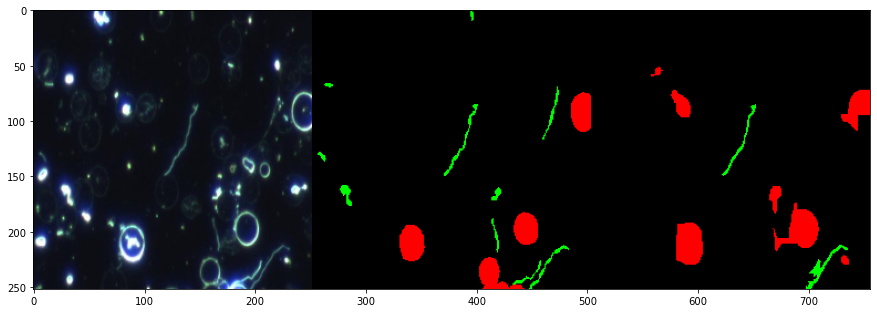

In [7]:
# get random data from dataset
i = np.random.randint(0, len(data))
image, mask = data[i]

# get ground truth mask
mask_true = list(cv2.split(mask))

# make prediction
init = time()
mask_pred = list(predict_masks(image, clf))
mask_pred = post_process(*mask_pred)

# adjust values
ery_true = np.where(mask_true[0]==255, 255, 0)
spi_true = np.where(mask_true[1]==255, 255, 0)
y_true = cv2.merge([ery_true, spi_true, np.zeros_like(ery_true)])

ery_pred = np.where(mask_pred[0]==255, 255, 0)
spi_pred = np.where(mask_pred[1]==255, 255, 0)
y_pred = cv2.merge([ery_pred, spi_pred, np.zeros_like(ery_pred)])
print('Elapsed time: ', time()-init)

# plot results
plt.figure(figsize=(15,10))
plt.imshow(np.hstack([image, y_true, y_pred]))